In [2]:
import os
import gc
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn

In [1]:
#===== CONSTANTS =====
DATA_PATH = './data/loaded.pckl'
RESIZE_RES = (224, 224)

In [3]:
data = pickle.load(open(DATA_PATH, 'rb'))

In [4]:
#Dataset is really unbalanced for now

dataframe = pd.DataFrame(data)
dataframe[1].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: 1, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from skimage.util import crop

data_X = []
data_y = []

for d in data:
    cropped = crop(d[0], ((0, 0), (75, 75), (0,0)), copy = False)
    resized = resize(cropped, RESIZE_RES)
    data_X.append(np.array(resized))
    data_y.append(d[1])
    
data = None

### Solutions to this unbalanced dataset
1. Undersampling of nv label
2. Image augumentation by rotation of bcc, akiec, vasc and df labels
3. Adding gausian blur to all labels
4. Custom class_weights

In [6]:
#Image augumentation by rotation
from skimage.transform import rotate

to_rotate = ['bcc', 'akiec', 'vasc', 'df']
degrees_of_rotation = [90, 180, 270]

original_lenght = len(data_X)
for i in range(0, original_lenght):
    img = data_X[i]
    label = data_y[i]
    if label in to_rotate:
        for angle in degrees_of_rotation:
            data_X.append(rotate(img, angle, resize = False))
            data_y.append(label)

In [7]:
dataframe_oversampled = pd.DataFrame(data_y)
dataframe_oversampled[0].value_counts()

nv       6705
bcc      2056
akiec    1308
mel      1113
bkl      1099
vasc      568
df        460
Name: 0, dtype: int64

In [8]:
#Image augumentation by adding gaussian blur
from skimage.filters import gaussian

to_blur_copy = ['akiec', 'mel', 'bkl', 'vasc', 'df']

blur_nv = False
blur_bcc = False
original_lenght = len(data_X)
for i in range(0, original_lenght):
    img = data_X[i]
    label = data_y[i]
    if label in to_blur_copy:
        data_X.append(gaussian(img, sigma = 10, truncate = 1/5))
        data_y.append(label)
    else:
        if (label == 'nv'):
            if (blur_nv):
                data_X[i] = gaussian(img, sigma = 10, truncate = 1/5)
            blur_nv = not blur_nv
        else:
            if (blur_bcc):
                data_X[i] = gaussian(img, sigma = 10, truncate = 1/5)
            blur_bcc = not blur_bcc
                

C:\Users\juraj\source\enviroments\MySkinTraining\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


In [9]:
dataframe_oversampled = pd.DataFrame(data_y)
dataframe_oversampled[0].value_counts()

nv       6705
akiec    2616
mel      2226
bkl      2198
bcc      2056
vasc     1136
df        920
Name: 0, dtype: int64

In [10]:
#Undersampling of nv label
import random

indexes_to_remove = []
while len(indexes_to_remove) < (6705 - 2616):
    current = random.randrange(0, len(data_X))
    if (data_y[current] == 'nv' and current not in indexes_to_remove):
        indexes_to_remove.append(current)
        
indexes_to_remove.sort(reverse = True)
for i in indexes_to_remove:
    data_X.pop(i)
    data_y.pop(i)

In [11]:
dataframe_oversampled = pd.DataFrame(data_y)
dataframe_oversampled[0].value_counts()

nv       2616
akiec    2616
mel      2226
bkl      2198
bcc      2056
vasc     1136
df        920
Name: 0, dtype: int64

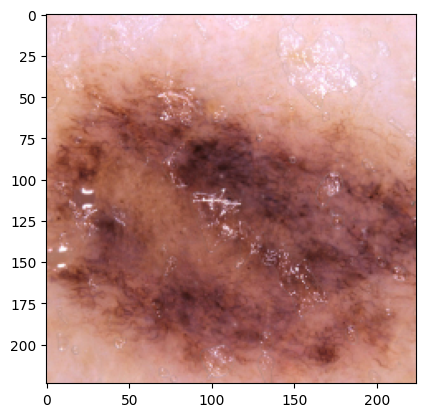

In [20]:
plt.imshow(data_X[5000])

In [ ]:
#Change units to floats